In [1]:
%matplotlib inline

In [2]:
import random
import numpy as np
import pandas as pd
import matplotlib.pylab as pl
from cadCAD.configuration import Configuration
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor

In [ ]:
# general setup
time_steps = 50 

#population settings
community = False
community_size_1 = 35
# not implemented yet
community_size_2 = 0 
# not implemented yet
between_com = 0      

#TCR settings - only voting implemented 
TCR = True            
reputation_threshold_for_voting = 500 # reputation tokens
voting_rate = False    # not imnplemented yet
voting_rate_value = 20 #% not implemented yet

#reputation token allocation

# for proof of positive action
rep_token_proof = True
# for claiming/receiving a token
rep_token_claim = True
rep_PAT_creator = False

#random OPATs
# the PATs are selected randomly for voting from the existing PAT list 
random_OPATs = True
# the selected PATs for voting are follow a fixed list of PAT ids
fixed_OPAT_sugestion = False
# the selected PATs from a fixed list become OPATs regardless of the vote results
fixed_OPATs = False


In [4]:
simulation_parameters = {
    'T': range(time_steps),
    'N': 1,
    'M': {}
}

In [5]:
def get_update_name(variable_name):
    return "add_" + variable_name

In [6]:
#general constants
TIMESTEP = 'timestep' # access to current timestep with s[TIMESTEP]
USERS = "users"
PATS = "pats"
OPATS = "opats"
WALLET_GAINS = "wallet_gains"
ADD_USERS = get_update_name(USERS)
ADD_PATS = get_update_name(PATS)

proposed_PAT_id = [5, 10, 15, 20, 25, 30, 35, 40]


In [7]:
initial_conditions = {
    USERS: {0:{}},  # users are numerical ids and a dictionary of their current wallet
    PATS: [0],      # pats are currently simply numerical ids except 3 special PATs: vote, reputation and governance
    OPATS: ()
}

#### Secondary Functions

In [8]:
def clear_PAT_list(pats):
    print("pats", pats)
    for i in range(0, len(pats)-1):
        try:
            if pats[i] == "vote":
                del pats[i]

            if pats[i] == "reputation":
                del pats[i]

            if pats[i] == "governance":
                del pats[i]
        except:
            pass
    print("cleaned pats: ", pats)
    return pats

In [9]:
def pat_proposal(users):
    choice = None
    p = users[PATS].copy()
    op = users[OPATS]
    ch_list_1 = clear_PAT_list(p)

    if fixed_OPAT_sugestion:
        if users[TIMESTEP] % 5 != 0:
            pass
        else:
            choice = users[TIMESTEP]
    else:
        if len(op) > 0 and op[0] != None:
            if ch_list_1 != None:
                if len(ch_list_1) > 0:
                    ch_list = set(ch_list_1) - set(list(op))
                    choice = random.choice(list(ch_list))
            else:
                choice = None
        else:
            choice = random.choice(p)
    return choice


In [10]:
def vote_result(users):
    yes = 0
    no = 0
    for u in range(0, len(users)):
        if 'vote' in users[u]:
            if users[u].get("vote") == 0:
                no += 1
            if users[u].get("vote") == 1:
                yes += 1
        else:
            pass
    if no == 0 and yes == 0 or no == yes:
        vote = None
    elif no > yes:
        vote = False
    elif no < yes:
        vote = True
    return vote

In [11]:
def distribute_tokens(users, pats, opats, gain, extra_gain):
    p = pats[3:]
    # at most all the PATs of a person get a token
    for u in users:
        # for each pat in a list of paths of random length and random values
        for pat in random.sample(p, random.randint(0, len(p))):
            gain[(u, pat)] = 1
        if opats != None:
            # if OPATs exist, every user will be allocated a token for each OPAT
            for opa in range(0, len(opats)):
                gain[(u, opats[opa])] = 1
    return gain


In [12]:
def get_rep_token(wallet, gain, n):
    if 'reputation' in wallet:
        wallet["reputation"] = wallet.get("reputation") + n * gain
    else :
        d = {"reputation": n}
        wallet.update(d)
    return wallet


In [13]:
def add_fixed_opat(timestep, opats):
    if timestep % 5 != 0:
        pass
    else:
        proposed_PAT_id = timestep
        opats = opats + tuple([proposed_PAT_id])
    return opats

In [14]:
def evaluate_vote_add_opat(prop_id, vote, opats):
    if vote == None or vote == False or prop_id == None:
        pass
    else:
        opats = opats + tuple([prop_id])
    if opats != None:
        if has_duplicates(opats):
            opats = get_rid_of_duplicates(opats)
    return opats

In [15]:
def has_duplicates(iterable):
    l = list(iterable)
    try:
        return len(set(iterable)) != len(iterable)
    except:
        l = list(iterable)
        return len(set(l)) != len(l)


In [16]:
def get_rid_of_duplicates(opats):
    l = list(opats)
    cleaned_list = list(dict.fromkeys(l))
    return tuple(cleaned_list)

#### Main Functions - to update at every time step

In [17]:
def create_users(params, step, sL, s):
    next_user_id = len(s[USERS])
    x = {ADD_USERS:[
        (next_user_id, {}),
    ]}
    if next_user_id == 1:
        u = s[USERS].copy()
        d = {"reputation": 1}
        u[0].update(d)
    return x

In [18]:
def create_pat(params, step, sL, s):
    next_pat_id = len(s[PATS])
    if next_pat_id >= 2:
        next_pat_id = len(s[PATS]) - 3
    x = {ADD_PATS:[next_pat_id,]}
    return x

In [19]:
def user_actions(params, step, sL, s):
    gain = {}
    gain_ext = {}
    if community:
        if s[TIMESTEP] <= setup.community_size_1:
            pass
        #if setup.community_size_2 > 0:
        #    if s[TIMESTEP] > (setup.community_size_1 + setup.between_com) and s[TIMESTEP] <= (setup.community_size_1 + setup.between_com + setup.community_size_2):
        #        pass
        #    else:
        #distribute_tokens(s[USERS], s[PATS], s[OPATS], gain, gain_ext)
        else:
            distribute_tokens(s[USERS], s[PATS], s[OPATS], gain, gain_ext)
    else:
        distribute_tokens(s[USERS], s[PATS], s[OPATS], gain, gain_ext)
    return {WALLET_GAINS: gain}

In [20]:
def user_vote(params, step, sL, s):
    x = s[USERS].copy()
    pat = pat_proposal(s)
    for u in range(0, len(x)-1):
        # ---------------F4-----fixed threshold or percentage
        if 'reputation' in x[u] and x[u].get("reputation") > reputation_threshold_for_voting:
            if "vote" in x[u]:
                v = random.randint(0, 1)
                d = {"vote": v}
                x[u].update(d)
            else:
                d = {"vote": 0}
                x[u].update(d)

    return ({'Vote':x, 'Proposed_pat':pat})


#### Main Funstions - to update the variables at every time step

In [21]:
def add_users(params, step, sL, s, _input):
    x = s[USERS].copy()
    for new_user_id, wallet in _input[ADD_USERS]:
        x[new_user_id] = wallet
    return (USERS, x)

In [22]:
def add_pat(params, step, sL, s, _input):
    x = s[PATS].copy()
    if len(x) <=2:
        initial = x
        spec = ['vote', 'reputation', 'governance']
        x = spec + initial
    x.extend(_input[ADD_PATS])
    #if setup.rep_PAT_owner:
    # ---------------F3-------------------------------------
    #add activity token to the user who comes up with the added token     - PAT_owner
        #u = s[USERS].copy()
        #matching_user = _input[ADD_PATS][0]
        #x = get_rep_token(u[user], 1, 1)
        #if u[matching_user].get("reputation", 0) == 0:
        #    d = {"reputation": 1}
        #    u[matching_user].update(d)
        #else:
        #    u[matching_user]["reputation"] = u[matching_user].get("reputation") + 1
    return (PATS, x)


In [23]:
def update_user_wallets(params, step, sL, s, _input):
    x = s[USERS].copy()
    changes = _input[WALLET_GAINS]
    for (user, pat), gain in changes.items():
        #add the token itself
        x[user][pat] = x[user].get(pat, 0) + gain
        if rep_token_claim:
            if rep_token_proof:
                # gain one reputation token for the proof of positive action
                # and one for receiving a token (of any kind)
                x[user] = get_rep_token(x[user], gain, 1)
                x[user] = get_rep_token(x[user], gain, 1)
            else:
                x[user] = get_rep_token(x[user], gain, 1)
        if rep_PAT_creator:
            x[user] = get_rep_token(x[user], gain, 1)
    return (USERS, x)

In [24]:
def opats(params, step, sL, s, _input):
    result = vote_result(_input["Vote"])
    proposed_PAT_id = None
    updated_opats = s[OPATS]
    if random_OPATs or fixed_OPAT_sugestion:
        proposed_PAT_id = _input["Proposed_pat"]
        updated_opats = evaluate_vote_add_opat(proposed_PAT_id, result, updated_opats)
    if fixed_OPATs:
        updated_opats = add_fixed_opat(s[TIMESTEP], s[OPATS])
    return (OPATS, updated_opats)


In [25]:
if TCR:
    partial_state_update_blocks = [
        {
            'policies': {
                'create_users': create_users,
            },
            'variables': {
                USERS: add_users,
            }
        },

        {
            'policies': {
                'create_pat': create_pat,
            },
            'variables': {
                PATS: add_pat,
            }
        },

        {
            'policies': {
                'user_actions': user_actions,
            },
            'variables': {
                USERS: update_user_wallets,
            }
        },
        {
            'policies': {
                'user_vote': user_vote,
            },
            'variables': {
                OPATS: opats,
            }
        },
    ]
else:
    partial_state_update_blocks = [
        {
            'policies': {
                'create_users': create_users,
            },
            'variables': {
                USERS: add_users,
            }
        },

        {
            'policies': {
                'create_pat': create_pat,
            },
            'variables': {
                PATS: add_pat,
            }
        },

        {
            'policies': {
                'user_actions': user_actions,
            },
            'variables': {
                USERS: update_user_wallets,
            }
        },
    ]

In [26]:
config = Configuration(initial_state=initial_conditions,                         #dict containing variable names and initial values
                       partial_state_update_blocks=partial_state_update_blocks,  #dict containing state update functions
                       sim_config=simulation_parameters                          #dict containing simulation parameters
                      )

exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.single_proc)
executor = Executor(exec_context, [config])                                       #Pass the configuration object inside an array
raw_result, tensor = executor.execute()



                            __________   ____ 
          ________ __ _____/ ____/   |  / __ \
         / ___/ __` / __  / /   / /| | / / / /
        / /__/ /_/ / /_/ / /___/ ___ |/ /_/ / 
        \___/\__,_/\__,_/\____/_/  |_/_____/  
        by BlockScience
        
Execution Mode: single_proc: [<cadCAD.configuration.Configuration object at 0x0000024FBD9DC828>]
Configurations: [<cadCAD.configuration.Configuration object at 0x0000024FBD9DC828>]
pats ['vote', 'reputation', 'governance', 0, 1]
cleaned pats:  [0, 1]
pats ['vote', 'reputation', 'governance', 0, 1, 2]
cleaned pats:  [0, 1, 2]
pats ['vote', 'reputation', 'governance', 0, 1, 2, 3]
cleaned pats:  [0, 1, 2, 3]
pats ['vote', 'reputation', 'governance', 0, 1, 2, 3, 4]
cleaned pats:  [0, 1, 2, 3, 4]
pats ['vote', 'reputation', 'governance', 0, 1, 2, 3, 4, 5]
cleaned pats:  [0, 1, 2, 3, 4, 5]
pats ['vote', 'reputation', 'governance', 0, 1, 2, 3, 4, 5, 6]
cleaned pats:  [0, 1, 2, 3, 4, 5, 6]
pats ['vote', 'reputation', 'governance'

pats ['vote', 'reputation', 'governance', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]
cleaned pats:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]
pats ['vote', 'reputation', 'governance', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]
cleaned pats:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]
pats ['vote', 'reputation', 'governance', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 

#### Name construction 

In [27]:
if TCR:
    name = "tcr_"
else:
    name = "s_"
name = name + "t" + str(time_steps) + "_c"
if community and community_size_1:
    if community_size_2:
        name = name + "11_"
    name = name + "1_"
else:
    name = name + "0_"
name = name + "vt" + str(reputation_threshold_for_voting)
if random_OPATs:
    name = name + "_rOPATs"
if fixed_OPATs:
    name = name + "_fOPATs"
if fixed_OPAT_sugestion:
    name = name + "_fsOPATs"

In [28]:
#### Data analysis

In [29]:
df = pd.DataFrame(raw_result)
t_step = raw_result[len(raw_result)-1]["timestep"]

In [30]:
def clean_PATS_of_special_tokens(s):
    if s.get("reputation", 0) != 0 or s.get("reputation") == 0:
        s.pop("reputation")

    if s.get("activity", 0) != 0 or s.get("activity") == 0:
        s.pop("activity")

    if s.get("vote", 0) != 0 or s.get("vote") == 0:
        s.pop("vote")

    if s.get("governance", 0) != 0 or s.get("governance") == 0:
        s.pop("governance")
    return s

In [31]:
def calculate_total_tokens_per_pat(state):
    distribution = {pat:0 for pat in state[PATS]}
    for user_wallet in state[USERS].values():
        for pat, number_of_tokens in user_wallet.items():
            distribution[pat] += number_of_tokens
    dist = clean_PATS_of_special_tokens(distribution)
    return dist

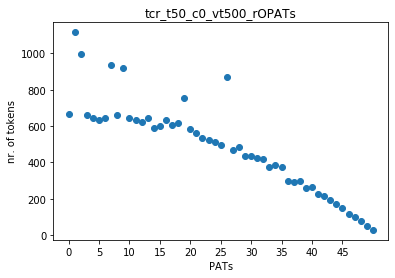

In [32]:
plt1 = pl.scatter(calculate_total_tokens_per_pat(raw_result[-1]).keys(),
           calculate_total_tokens_per_pat(raw_result[-1]).values())

pl.xticks(np.arange(0, t_step, 5))
pl.title(name)
pl.xlabel("PATs")
pl.ylabel("nr. of tokens")
pl.savefig(name + ".png")
pl.show()